In [1]:
shared_cts = ['L6_IT_CTX_Glut',
 'CA1-ProS_Glut',
 'STR-PAL_Chst9_Gaba',
 'Pvalb_Gaba',
 'L23_IT_ENT_Glut',
 'OPC_NN',
 'L23_IT_CTX_Glut',
 'L5_ET_CTX_Glut',
 'L23_IT_PPP_Glut',
 'Lamp5_Gaba',
 'CA3_Glut',
 'Sst_Gaba',
 'LA-BLA-BMA-PA_Glut',
 'SUB-ProS_Glut',
 'Microglia_NN',
 'Astro-NT_NN',
 'Oligo_NN',
 'L6_CT_CTX_Glut',
 'L5_NP_CTX_Glut',
 'Vip_Gaba',
 'STR_D1_Sema5a_Gaba',
 'Astro-TE_NN',
 'DG_Glut',
 'VLMC_NN',
 'L6bCT_ENT_Glut',
 ] #'STR_D1_Gaba'

In [3]:
def get_luisa_deg(ct):
    deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
    expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
    use_genes = expr[expr.sum(axis = 1) > 0.1].index
    stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)
    
    luisa_deg = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
    luisa_deg['log2(18mo/2mo)'] = np.log2(luisa_deg['fc']) 
    luisa_deg['-log10(padj)'] = -np.log10(luisa_deg['fdr'] + _min)
    luisa_deg =luisa_deg[luisa_deg['fdr'] < 0.05]
    return luisa_deg

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [5]:
pvalue_cutoff = 0.05
fc_cutoff = 0.1
_min = 1e-200
res = 25000

In [6]:
all_diff_domain = pd.read_csv('ALL.Diff.Domain.csv', index_col = 0)
all_diff_domain = all_diff_domain[all_diff_domain['celltype'].isin(shared_cts)]

example_cts = all_diff_domain['celltype'].value_counts().index[:6]
example_cts

Index(['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut', 'Astro-TE_NN',
       'CA3_Glut', 'L6_CT_CTX_Glut'],
      dtype='object', name='celltype')

In [7]:
luisa_dir = '/data/female-amb/Diff.Result/luisa_deg'
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]

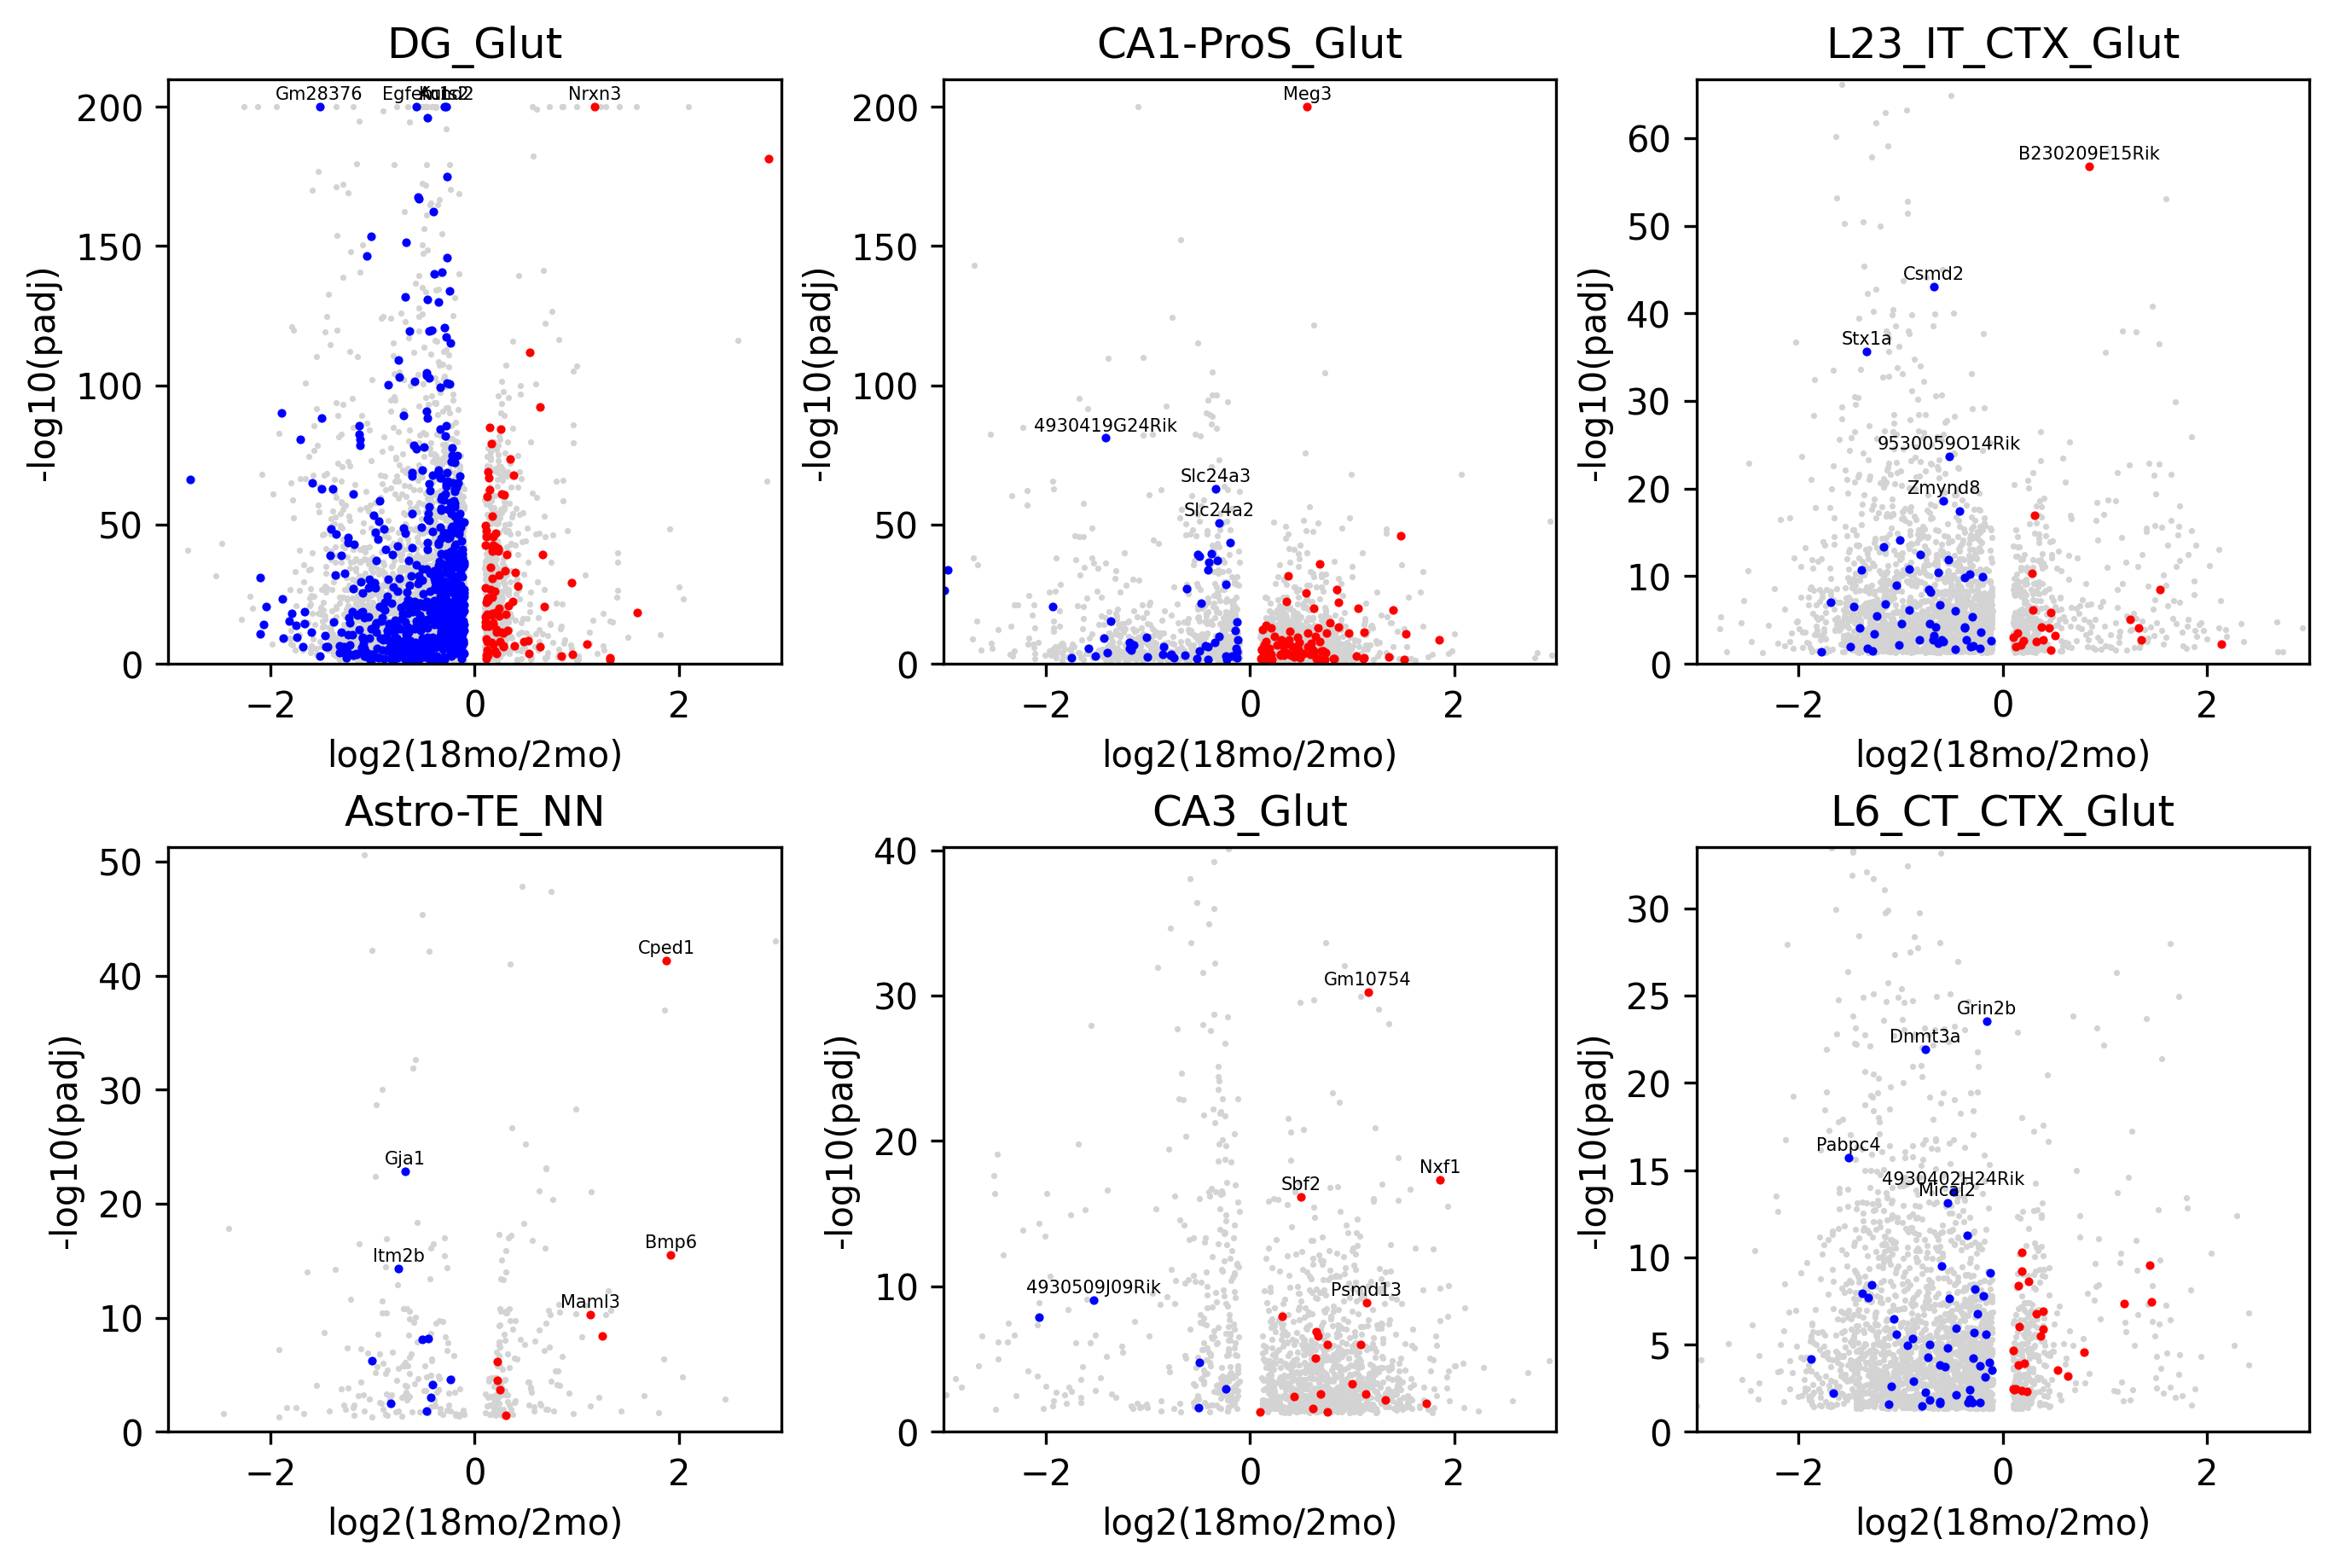

In [43]:
ncols = 3
nrows = 2
#cross_boundary = True
fig, axes = plt.subplots(figsize = (ncols*3,nrows*3), 
                         ncols = ncols, nrows = nrows, 
                         dpi = 300, constrained_layout = True)
for ct, ax in zip(example_cts,axes.ravel()):
    all_deg = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
    all_deg['-log10(padj)'] = -np.log10(all_deg['p_val_adj']+ _min)
    all_deg['log2(18mo/2mo)'] = -all_deg['avg_log2FC']
    all_deg = all_deg[(abs(all_deg['log2(18mo/2mo)']) > fc_cutoff) & (all_deg['p_val_adj'] <  pvalue_cutoff)]
    
    all_overlap = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col ='gene_name')
    all_overlap= all_overlap[all_overlap['18mo-8wk'] > 0.01]
    all_overlap['start'] = all_overlap['start'] - res
    all_overlap['end'] = all_overlap['end'] - res

    
    # if cross_boundary == True:
    #     cross_boundary_genes_1 = all_overlap[(all_overlap['gene_start'] < all_overlap['start']) & (all_overlap['gene_end'] > all_overlap['start'])]
    #     cross_boundary_genes_2 = all_overlap[(all_overlap['gene_end'] > all_overlap['end']) & (all_overlap['gene_start'] < all_overlap['end'])]
    #     all_overlap = pd.concat([cross_boundary_genes_1, cross_boundary_genes_2])
    # elif cross_boundary == False:
    #     cross_boundary_genes_1 = all_overlap[(all_overlap['gene_start'] < all_overlap['start']) & (all_overlap['gene_end'] > all_overlap['start'])]
    #     cross_boundary_genes_2 = all_overlap[(all_overlap['gene_end'] > all_overlap['end']) & (all_overlap['gene_start'] < all_overlap['end'])]
    #     tmp = pd.concat([cross_boundary_genes_1, cross_boundary_genes_2])
    #     all_overlap = all_overlap[~all_overlap.index.isin(tmp.index)]
    
    shared_deg_df = all_deg[all_deg.index.isin(all_overlap.index)]    
    sns.scatterplot(data = all_deg,
                    linewidth = 0,
                    ax = ax,
                    rasterized = True,
                    color = 'lightgrey',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

    sns.scatterplot(data = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] < 0],
                    linewidth = 0,
                    ax = ax,
                    rasterized = True,
                    color = 'blue',
                    s = 6,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

    sns.scatterplot(data = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] > 0],
                    linewidth = 0,
                    ax = ax,
                    rasterized = True,
                    color = 'red',
                    s = 6,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')
    ax.set_title(ct)
    ylim = shared_deg_df['-log10(padj)'].max() + 10
    # if ylim > 200:
    #     ylim = 150
    ax.set(xlim = (-3,3), ylim = (0,ylim) ) #
    
    #top_genes = shared_deg_df[(shared_deg_df['log2(18mo/2mo)'] < -0.8)]
    top_genes = shared_deg_df.sort_values('-log10(padj)',ascending = False).head(5)
    for _, row in top_genes.iterrows():
        ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
                    textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)

fig.savefig(f"scatterplot.domain_all_deg.pdf", bbox_inches = 'tight')

## plot ratio

In [64]:
# drop Astro-TE_NN
example_cts = ['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut', 'Astro-TE_NN','CA3_Glut', 'L6_CT_CTX_Glut']

In [48]:
domain_deg_number = {}
all_deg_number = {}
#cross_boundary = False
for ct in example_cts:
    all_overlap = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col ='gene_name')
    all_overlap= all_overlap[all_overlap['18mo-8wk'] > 0]
    all_overlap['start'] = all_overlap['start'] - res
    all_overlap['end'] = all_overlap['end'] - res
    
    # if cross_boundary:
    #     cross_boundary_genes_1 = all_overlap[(all_overlap['gene_start'] < all_overlap['start']) & (all_overlap['gene_end'] > all_overlap['start'])]
    #     cross_boundary_genes_2 = all_overlap[(all_overlap['gene_end'] > all_overlap['end']) & (all_overlap['gene_start'] < all_overlap['end'])]
    #     all_overlap = pd.concat([cross_boundary_genes_1, cross_boundary_genes_2])
    # elif cross_boundary == False:
    #     cross_boundary_genes_1 = all_overlap[(all_overlap['gene_start'] < all_overlap['start']) & (all_overlap['gene_end'] > all_overlap['start'])]
    #     cross_boundary_genes_2 = all_overlap[(all_overlap['gene_end'] > all_overlap['end']) & (all_overlap['gene_start'] < all_overlap['end'])]
    #     tmp = pd.concat([cross_boundary_genes_1, cross_boundary_genes_2])
    #     all_overlap = all_overlap[~all_overlap.index.isin(tmp.index)]
        
    all_deg = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
    all_deg['-log10(padj)'] = -np.log10(all_deg['p_val_adj']+ _min)
    all_deg['log2(18mo/2mo)'] = -all_deg['avg_log2FC']
    all_deg = all_deg[(abs(all_deg['log2(18mo/2mo)']) > fc_cutoff) & (all_deg['p_val_adj'] <  pvalue_cutoff)]
    
    
    shared_deg_df = all_deg[all_deg.index.isin(all_overlap.index)]
    down_genes, up_genes = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] < 0].shape[0], shared_deg_df[shared_deg_df['log2(18mo/2mo)']> 0].shape[0]
    domain_deg_number[ct] = (down_genes, up_genes)

    # non_domain_genes
    all_deg = all_deg[~all_deg.index.isin(all_overlap.index)]
    down_genes, up_genes = all_deg[all_deg['log2(18mo/2mo)'] < 0].shape[0], all_deg[all_deg['log2(18mo/2mo)']> 0].shape[0]
    all_deg_number[ct] = (down_genes, up_genes)

In [49]:
all_deg_number = pd.DataFrame(all_deg_number, index = ['down_genes','up_genes']).T
all_deg_number['down_ratio'] = all_deg_number['down_genes']/(all_deg_number['down_genes'] + all_deg_number['up_genes'])
all_deg_number['down_genes'] *= -1
all_deg_number['cell_type'] = all_deg_number.index
all_deg_number

,down_genes,up_genes,down_ratio,cell_type
DG_Glut,-4002,631,0.863803,DG_Glut
CA1-ProS_Glut,-733,1175,0.384172,CA1-ProS_Glut
L23_IT_CTX_Glut,-1917,489,0.796758,L23_IT_CTX_Glut
Astro-TE_NN,-153,149,0.506623,Astro-TE_NN
CA3_Glut,-322,1040,0.236417,CA3_Glut
L6_CT_CTX_Glut,-1964,341,0.852061,L6_CT_CTX_Glut


In [50]:
domain_deg_number = pd.DataFrame(domain_deg_number, index = ['down_genes','up_genes']).T
domain_deg_number['down_ratio'] = domain_deg_number['down_genes']/(domain_deg_number['down_genes'] + domain_deg_number['up_genes'])
domain_deg_number['down_genes'] *= -1
domain_deg_number['cell_type'] = domain_deg_number.index
domain_deg_number

,down_genes,up_genes,down_ratio,cell_type
DG_Glut,-674,93,0.878748,DG_Glut
CA1-ProS_Glut,-51,84,0.377778,CA1-ProS_Glut
L23_IT_CTX_Glut,-51,21,0.708333,L23_IT_CTX_Glut
Astro-TE_NN,-10,8,0.555556,Astro-TE_NN
CA3_Glut,-5,19,0.208333,CA3_Glut
L6_CT_CTX_Glut,-48,23,0.676056,L6_CT_CTX_Glut


In [51]:
ct_order = ['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut', 'Astro-TE_NN','CA3_Glut', 'L6_CT_CTX_Glut']

/var/tmp/ipykernel_175817/284582573.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{txt:.2f}', (all_deg_number['down_genes'][i] - 50, i), fontsize = 5)
/var/tmp/ipykernel_175817/284582573.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{txt:.2f}', (domain_deg_number['down_genes'][i] - 50, i), fontsize = 5)


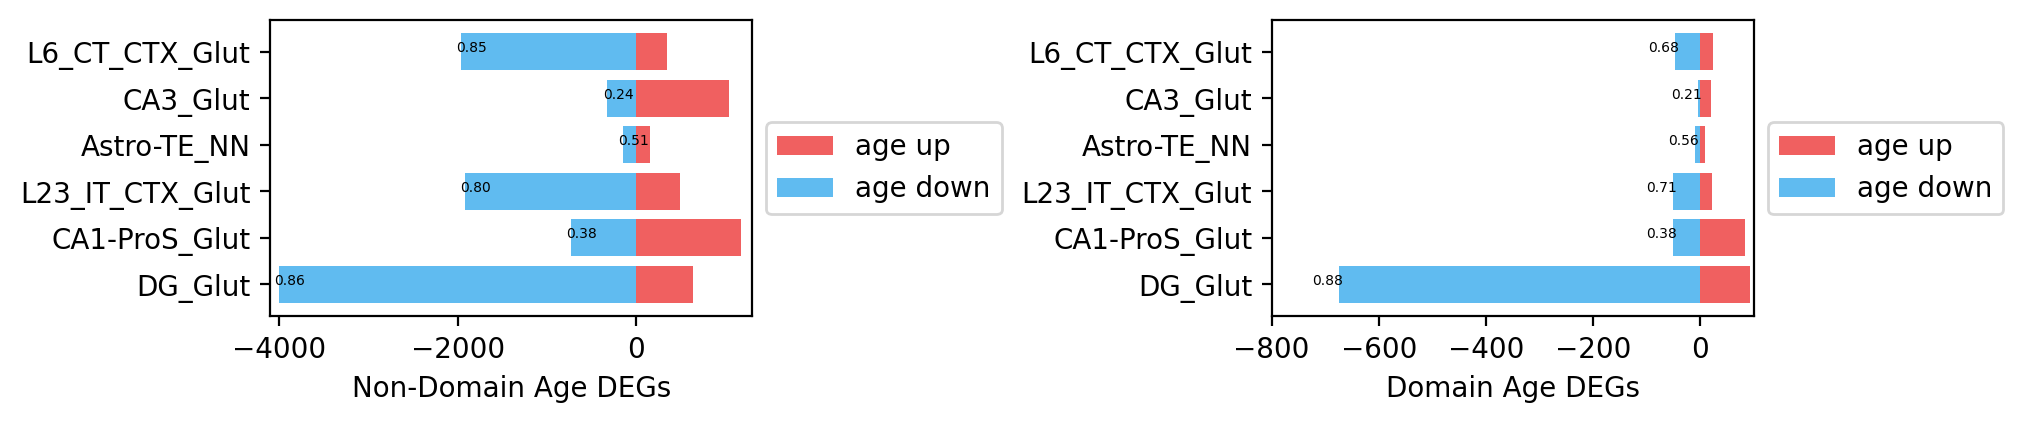

In [71]:
# Plotting
fig, axes = plt.subplots(figsize = (10,2), ncols= 2, dpi = 200,constrained_layout = True)

ax = axes[0]
ax.barh(all_deg_number['cell_type'],  all_deg_number['up_genes'],  color='#f06060',label='age up')
# Bar plot for down genes
ax.barh(all_deg_number['cell_type'], all_deg_number['down_genes'], color='#60bbf0', label='age down')
ax.set_xlabel('Non-Domain Age DEGs')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(-4100, 1300)
# laybel the down_ratio
for i, txt in enumerate(all_deg_number['down_ratio']):
    ax.annotate(f'{txt:.2f}', (all_deg_number['down_genes'][i] - 50, i), fontsize = 5)


ax = axes[1]
ax.barh(domain_deg_number['cell_type'], domain_deg_number['up_genes'],  color='#f06060',label='age up')
# Bar plot for down genes
ax.barh(domain_deg_number['cell_type'], domain_deg_number['down_genes'], color='#60bbf0', label='age down')
ax.set_xlabel('Domain Age DEGs')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(-800, 100)
for i, txt in enumerate(domain_deg_number['down_ratio']):
    ax.annotate(f'{txt:.2f}', (domain_deg_number['down_genes'][i] - 50, i), fontsize = 5)

plt.show()
fig.savefig(f"barplot_domain_genes.up_or_down_number.pdf", bbox_inches = 'tight')

In [55]:
ratio = pd.concat([all_deg_number['down_ratio'], domain_deg_number['down_ratio']], axis = 1)
ratio.columns = ['non_domain_deg_down_ratio', 'domain_deg_down_ratio']
ratio['celltype'] = ratio.index
ratio

,non_domain_deg_down_ratio,domain_deg_down_ratio,celltype
DG_Glut,0.863803,0.878748,DG_Glut
CA1-ProS_Glut,0.384172,0.377778,CA1-ProS_Glut
L23_IT_CTX_Glut,0.796758,0.708333,L23_IT_CTX_Glut
Astro-TE_NN,0.506623,0.555556,Astro-TE_NN
CA3_Glut,0.236417,0.208333,CA3_Glut
L6_CT_CTX_Glut,0.852061,0.676056,L6_CT_CTX_Glut


In [58]:
# statiscally evaluate if ratio is different
from scipy.stats import ttest_ind
ttest_ind(ratio['non_domain_deg_down_ratio'], ratio['domain_deg_down_ratio'])

TtestResult(statistic=0.2655663236624285, pvalue=0.7959676938966529, df=10.0)

/var/tmp/ipykernel_175817/3016193883.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{txt:.3f}', (i-0.4, ratio['non_domain_deg_down_ratio'][i]), fontsize = 5)
/var/tmp/ipykernel_175817/3016193883.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{txt:.3f}', (i+ 0, ratio['domain_deg_down_ratio'][i]), fontsize = 5)


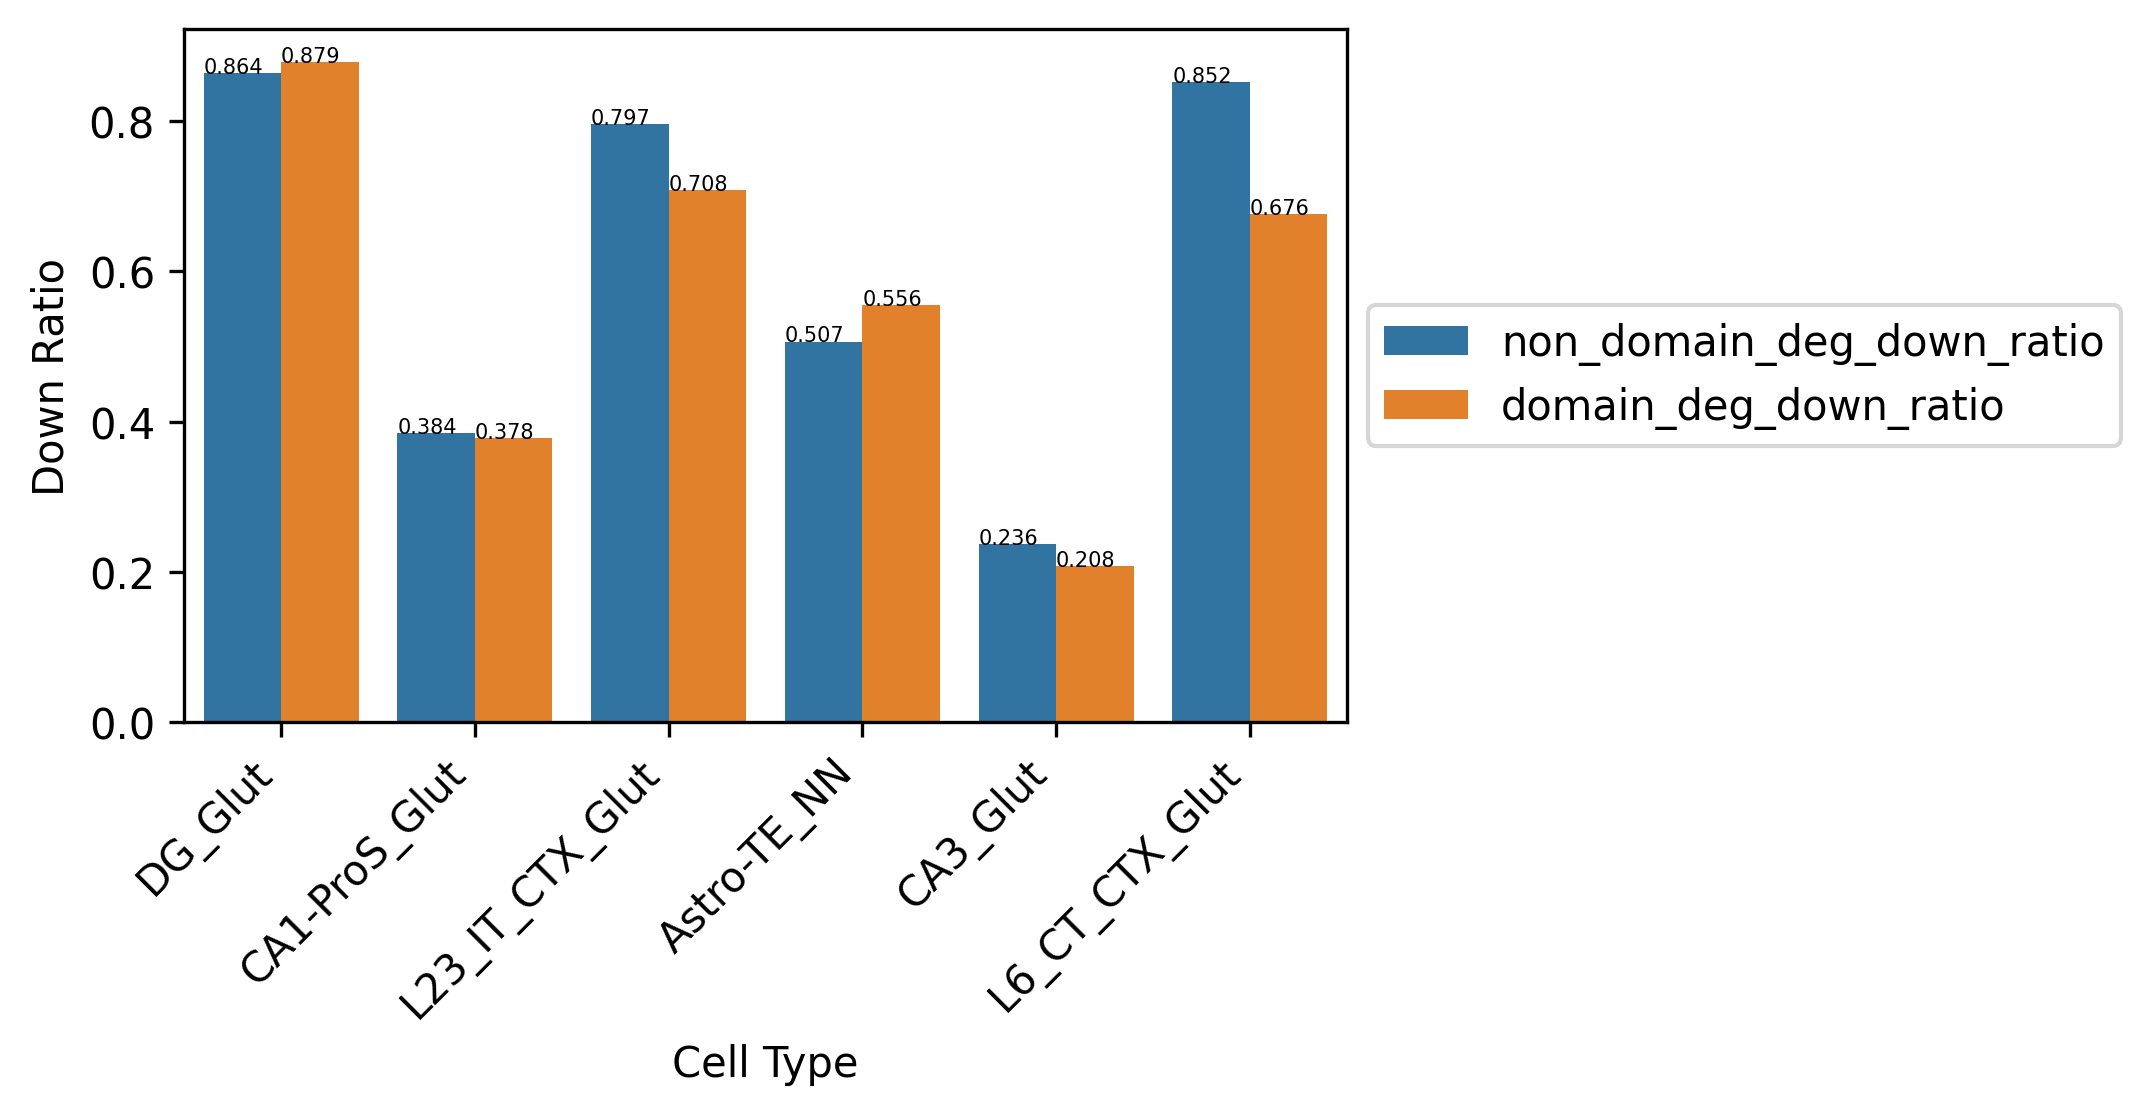

In [62]:
## barplot x= celltype, y = down_ratio, hue = all/domain, make it dodge = True
fig, ax = plt.subplots(figsize = (5,3), dpi = 300)
sns.barplot(data = ratio.melt(id_vars = 'celltype'), x = 'celltype', y = 'value', hue = 'variable', ax = ax)
ax.set_ylabel('Down Ratio')
ax.set_xlabel('Cell Type')
# move legend to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# annot the ratio on the bar
for i, txt in enumerate(ratio['non_domain_deg_down_ratio']):
    ax.annotate(f'{txt:.3f}', (i-0.4, ratio['non_domain_deg_down_ratio'][i]), fontsize = 5)
for i, txt in enumerate(ratio['domain_deg_down_ratio']):
    ax.annotate(f'{txt:.3f}', (i+ 0, ratio['domain_deg_down_ratio'][i]), fontsize = 5)
plt.show()
fig.savefig(f"domain_genes.down_ratio.pdf", bbox_inches = 'tight')

,all_deg_down_ratio,domain_deg_down_ratio
DG_Glut,0.865926,0.878748
CA1-ProS_Glut,0.383749,0.377778
L23_IT_CTX_Glut,0.794189,0.708333
Astro-TE_NN,0.509375,0.555556
CA3_Glut,0.235931,0.208333
L6_CT_CTX_Glut,0.846801,0.676056
